# Tutorial 3: Splicing MPRA modeling using multiple built-in G-P maps

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import MAVE-NN
import mavenn

# Import Logomaker for visualization
import logomaker

In this tutorial we show how to train multiple models with different G-P maps on the same dataset. To this end we use the built-in `'mpsa'` dataset, which contains data from the splicing MPRA of Wong et al. (2018). Next we show how to to compare the performance of these models, as in Figs. 5a-5d of Tareen et al. (2020). Finally, we demonstrate how to visualize the parameters of the `'pairwise'` G-P map trained on these data; similar visualizations are shown in Figs. 5e and 5f of Tareen et al. (2020).

## Training multiple models

The models that we train each have a  GE measurement process and one of four different types of G-P map: additive, neighbor, pairwise, or blackbox. The  trained models are similar (though not identical) to the following built-in models, which  can be loaded with `mavenn.load_example_model()`:

- `'mpsa_additive_ge'`
- `'mpsa_neighbor_ge'`
- `'mpsa_pairwise_ge'`
- `'mpsa_blackbox_ge'`

First we load, split, and preview the built-in `'mpsa'` dataset. We also compute the length of sequences in this dataset.

In [2]:
# Load amyloid dataset
data_df = mavenn.load_example_dataset('mpsa')

# Get and report sequence length
L = len(data_df.loc[0,'x'])
print(f'Sequence length: {L:d} RNA nucleotides')

# Split dataset
trainval_df, test_df = mavenn.split_dataset(data_df)

# Preview trainval_df
print('\ntrainval_df:')
trainval_df

Sequence length: 9 RNA nucleotides
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)


trainval_df:


,validation,tot_ct,ex_ct,y,x
0,False,28,2,0.023406,GGAGUGAUG
1,False,193,15,-0.074999,UUCGCGCCA
2,False,27,0,-0.438475,UAAGCUUUU
3,False,130,2,-0.631467,AUGGUCGGG
4,False,552,19,-0.433012,AGGGCAGGA
...,...,...,...,...,...
24400,False,167,1467,1.950100,GAGGUAAAU
24401,False,682,17,-0.570465,AUCGCUAGA
24402,False,190,17,-0.017078,CUGGUUGCA
24403,False,154,10,-0.140256,CGCGCACAA


Next we instantiate and train our models. In order to train multiple different models in a consistent manner, we use dictionaries to specify default keyword arguments for `model.Model()`  and `model.fit()`. Then for each type of G-P map we do the following:
1. Modify the hyperparameter dictionaries as desired.
2. Instantiate a model using these hyperparameters.
3. Set that model's training data.
4. Train the parameters of that model.
5. Evaluate that model's performance.
6. Save that model to disk.

In [3]:
# Set default keyword arguments for model.Model()
default_model_kwargs = {
    'L':L,
    'alphabet':'rna',
    'regression_type':'GE',
    'ge_noise_model_type':'SkewedT',
    'ge_heteroskedasticity_order':2
}

# Set default keyword arguments for model.fit()
default_fit_kwargs = {
    'learning_rate':.001,
    'epochs':5,
    'batch_size':200,
    'early_stopping':True,
    'early_stopping_patience':30,
    'linear_initialization':False,
    'verbose':False
}

# Iterate over types of G-P maps
gpmap_types = ['additive','neighbor','pairwise','blackbox']
print(f'Training {len(gpmap_types)} models: {gpmap_types}')
for gpmap_type in gpmap_types:

    # Set model name
    model_name = f'mpsa_{gpmap_type}_ge'
    print('-----------------------------')
    print(f"Training '{model_name}' model...\n")

    # Copy keyword arguments
    model_kwargs = default_model_kwargs.copy()
    fit_kwargs = default_fit_kwargs.copy()

    # Modify keyword arguments based on G-P map being trained
    # Note: the need for different hyperparameters, such as batch_size
    # and learning_rate, was found by trial and error.
    if gpmap_type=='additive': pass;
    elif gpmap_type=='neighbor': pass;
    elif gpmap_type=='pairwise':
        fit_kwargs['batch_size'] = 50
    elif gpmap_type=='blackbox':
        model_kwargs['gpmap_kwargs'] = {'hidden_layer_sizes':[10]*5,
                                        'features':'pairwise'}
        fit_kwargs['learning_rate'] = 0.0005
        fit_kwargs['batch_size'] = 50
        fit_kwargs['early_stopping_patience'] = 10

    # Instantiate model using the keyword arguments in model_kwargs dict
    model = mavenn.Model(gpmap_type=gpmap_type, **model_kwargs)

    # Set training data
    model.set_data(x=trainval_df['x'],
                   y=trainval_df['y'],
                   validation_flags=trainval_df['validation'])

    # Train model using the keyword arguments in fig_kwargs dict
    model.fit(**fit_kwargs)

    # Compute variational information on test data
    I_var, dI_var =  model.I_variational(x=test_df['x'], y=test_df['y'])
    print(f'test_I_var: {I_var:.3f} +- {dI_var:.3f} bits')

    # Compute predictive information on test data
    I_pred, dI_pred = model.I_predictive(x=test_df['x'], y=test_df['y'])
    print(f'test_I_pred: {I_pred:.3f} +- {dI_pred:.3f} bits')

    # Save model to file
    model.save(model_name)

print('Done!')

Training 4 models: ['additive', 'neighbor', 'pairwise', 'blackbox']
-----------------------------
Training 'mpsa_additive_ge' model...

N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.223 sec.


0epoch [00:00, ?epoch/s]

Training time: 1.2 seconds
test_I_var: -0.140 +- 0.028 bits
test_I_pred: 0.059 +- 0.010 bits
Model saved to these files:
	mpsa_additive_ge.pickle
	mpsa_additive_ge.h5
-----------------------------
Training 'mpsa_neighbor_ge' model...

N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.217 sec.


0epoch [00:00, ?epoch/s]

Training time: 1.3 seconds
test_I_var: -0.101 +- 0.024 bits
test_I_pred: 0.164 +- 0.009 bits
Model saved to these files:
	mpsa_neighbor_ge.pickle
	mpsa_neighbor_ge.h5
-----------------------------
Training 'mpsa_pairwise_ge' model...

N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.215 sec.


0epoch [00:00, ?epoch/s]

Training time: 2.1 seconds
test_I_var: 0.188 +- 0.025 bits
test_I_pred: 0.324 +- 0.013 bits
Model saved to these files:
	mpsa_pairwise_ge.pickle
	mpsa_pairwise_ge.h5
-----------------------------
Training 'mpsa_blackbox_ge' model...

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.216 sec.


0epoch [00:00, ?epoch/s]

Training time: 3.0 seconds
test_I_var: 0.320 +- 0.026 bits
test_I_pred: 0.403 +- 0.015 bits
Model saved to these files:
	mpsa_blackbox_ge.pickle
	mpsa_blackbox_ge.h5
Done!


## Visualizing model performance

To compare these models side-by-side, we first load them into a dictionary.

In [4]:
# Iterate over types of G-P maps
gpmap_types = ['additive','neighbor','pairwise','blackbox']

# Create list of model names
model_names = [f'mpsa_{gpmap_type}_ge' for gpmap_type in gpmap_types]

# Load models into a dictionary indexed by model name
model_dict = {name:mavenn.load(name) for name in model_names}

Model loaded from these files:
	mpsa_additive_ge.pickle
	mpsa_additive_ge.h5
Model loaded from these files:
	mpsa_neighbor_ge.pickle
	mpsa_neighbor_ge.h5
Model loaded from these files:
	mpsa_pairwise_ge.pickle
	mpsa_pairwise_ge.h5
Model loaded from these files:
	mpsa_blackbox_ge.pickle
	mpsa_blackbox_ge.h5


To compare the performance of these models, we plot variational and predictive
information in the form of a bar chart similar to that shown in Fig. 5a of
Tareen et al., (2021).

Contents of info_df:
               name     gpmap  metric         I        dI
0  mpsa_additive_ge  additive   I_var -0.152251  0.024977
1  mpsa_additive_ge  additive  I_pred  0.058887  0.011109
2  mpsa_neighbor_ge  neighbor   I_var -0.092292  0.020540
3  mpsa_neighbor_ge  neighbor  I_pred  0.168971  0.013866
4  mpsa_pairwise_ge  pairwise   I_var  0.192587  0.027062
5  mpsa_pairwise_ge  pairwise  I_pred  0.327380  0.012934
6  mpsa_blackbox_ge  blackbox   I_var  0.335930  0.020831
7  mpsa_blackbox_ge  blackbox  I_pred  0.415347  0.013392


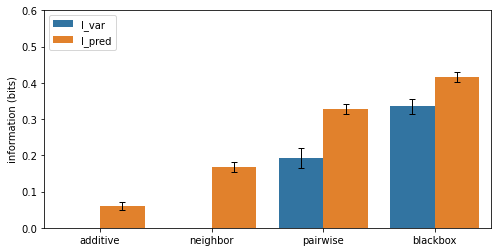

In [5]:
# Fill out dataframe containing values to plot
# This dataframe will then be used by seaborn's barplot() function
info_df = pd.DataFrame(columns=['name', 'gpmap', 'metric', 'I', 'dI'])
for gpmap_type in gpmap_types:

    # Get model
    name = f'mpsa_{gpmap_type}_ge'
    model = model_dict[name]

    # Compute variational information on test data
    I_var, dI_var =  model.I_variational(x=test_df['x'], y=test_df['y'])
    row = {'name':name,
           'gpmap':gpmap_type,
           'metric':'I_var',
           'I':I_var,
           'dI':dI_var}
    info_df = info_df.append(row, ignore_index=True)

    # Compute predictive information on test data
    I_pred, dI_pred = model.I_predictive(x=test_df['x'], y=test_df['y'])
    row = {'name':name,
           'gpmap':gpmap_type,
           'metric':'I_pred',
           'I':I_pred,
           'dI':dI_pred}
    info_df = info_df.append(row, ignore_index=True)

# Print dataframe
print('Contents of info_df:', info_df, sep='\n')

# Create figure
fig, ax = plt.subplots(figsize=[8, 4])

# Plot bars
sns.barplot(ax=ax,
            data=info_df,
            hue='metric',
            x='gpmap',
            y='I')

# Plot errorbars
x = np.array([[x-.2,x+.2] for x in range(4)]).ravel()
ax.errorbar(x=x,
            y=info_df['I'].values,
            yerr=info_df['dI'].values,
            color='k', capsize=3, linestyle='none',
            elinewidth=1, capthick=1, solid_capstyle='round')

ax.set_ylabel('information (bits)')
ax.set_xlabel('')
ax.set_xlim([-.5, 3.5])
ax.set_ylim([0, 0.6])
ax.legend(loc='upper left')

It can also be useful to observe the training history of each model in relation to performance metrics on the test set.

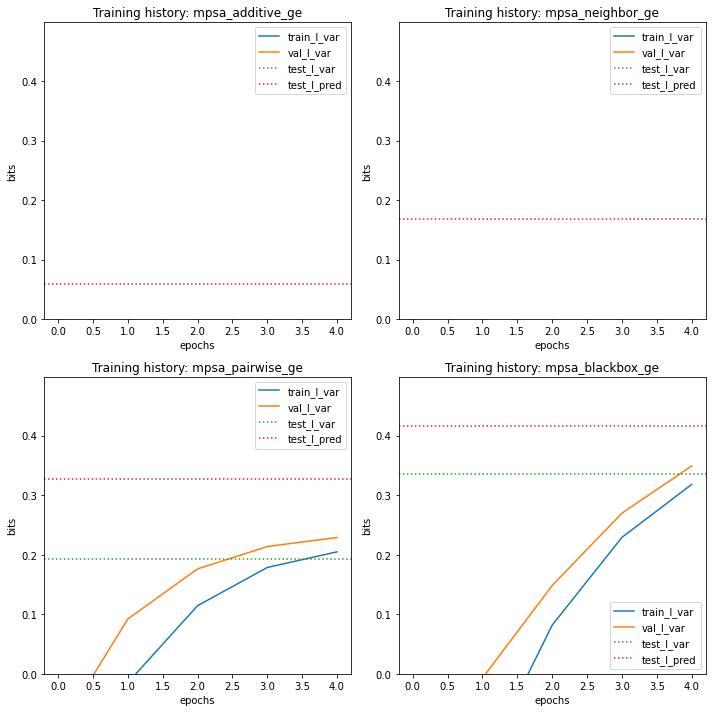

In [6]:
# Create figure and axes for plotting
fig, axs = plt.subplots(2,2,figsize=[10,10])
axs = axs.ravel()

# Loop over models
for ax, name in zip(axs, model_names):

    # Get model
    model = model_dict[name]

    # Plot I_var_train, the variational information on training data as a function of epoch
    ax.plot(model.history['I_var'],
            label=r'train_I_var')

    # Plot I_var_val, the variational information on validation data as a function of epoch
    ax.plot(model.history['val_I_var'],
            label=r'val_I_var')

    # Get part of info_df referring to this model and index by metric
    ix = (info_df['name']==name)
    sub_df = info_df[ix].set_index('metric')

    # Show I_var_test, the variational information of the final model on test data
    ax.axhline(sub_df.loc['I_var','I'], color='C2', linestyle=':',
               label=r'test_I_var')

    # Show I_pred_test, the predictive information of the final model on test data
    ax.axhline(sub_df.loc['I_pred','I'], color='C3', linestyle=':',
               label=r'test_I_pred')

    # Style plot
    ax.set_xlabel('epochs')
    ax.set_ylabel('bits')
    ax.set_title(f'Training history: {name}')
    ax.set_ylim([0, 1.2*I_pred])
    ax.legend()

# Clean up figure
fig.tight_layout()



Next we visualize the GE measurement process inferred as part of our each
latent phenotype model, comparing it to the test data.

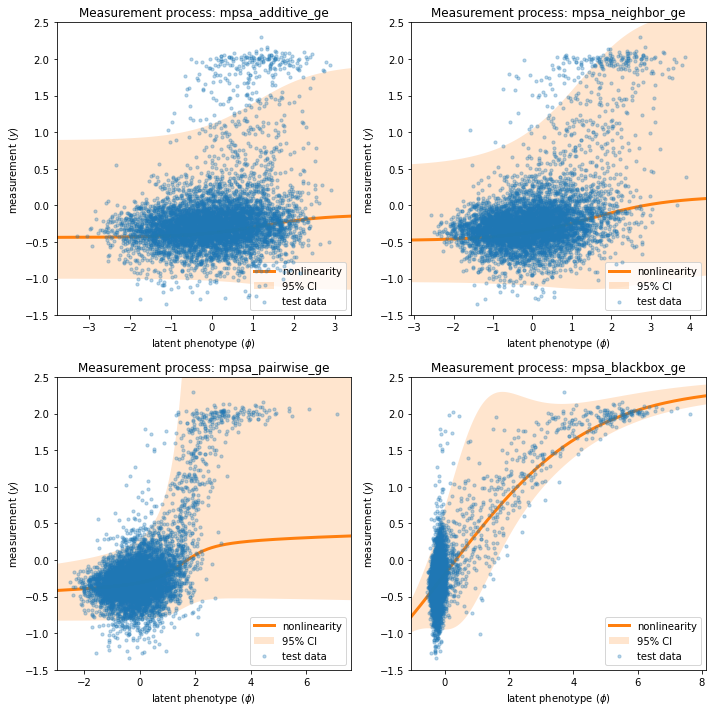

In [7]:
# Create figure and axes for plotting
fig, axs = plt.subplots(2,2,figsize=[10,10])
axs = axs.ravel()

# Loop over models
for ax, name in zip(axs, model_names):

    # Get model
    model = model_dict[name]

    # Get test data y values
    y_test = test_df['y']

    # Compute phi on test data
    phi_test = model.x_to_phi(test_df['x'])

    ## Set phi lims and create a grid in phi space
    phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
    phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

    # Compute yhat for each phi gridpoint
    yhat_grid = model.phi_to_yhat(phi_grid)

    # Compute 95% CI for each yhat
    q = [0.025, 0.975]
    yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

    # Plote 95% confidence interval
    ax.fill_between(phi_grid, yqs_grid[:, 0], yqs_grid[:, 1],
                    alpha=0.2, color='C1', lw=0, label='95% CI')

    # Plot GE nonlinearity
    ax.plot(phi_grid, yhat_grid,
            linewidth=3, color='C1', label='nonlinearity')

    # Plot scatter of phi and y values.
    ax.scatter(phi_test, y_test,
               color='C0', s=10, alpha=.3, label='test data', zorder=+100)

    # Style plot
    ax.set_xlim(phi_lim)
    ax.set_xlabel('latent phenotype ($\phi$)')
    ax.set_ylim([-1.5,2.5])
    ax.set_ylabel('measurement ($y$)')
    ax.set_title(f'Measurement process: {name}')
    ax.legend(loc='lower right')

fig.tight_layout()

Note that the measurement processes for all of the linear models (`'additive'`, `'neighbor'`, `'pairwise'`) are similar, while that of the `'blackbox'` model is quite different. This distinct behavior is due to the presence of nonlinearities in the `'blackbox'` G-P map that are not present in the other three.

## Visualizing pairwise model parameters

We now focus on visualizing the pairwise model. The mathematical formula for the pairwise G-P map is:

$$\phi_\mathrm{pairwise} (x;\theta) = \theta_0 + \sum_{l} \sum_{c} \theta_{l:c} x_{l:c} + \sum_{l < l'} \sum_{c,c'}  \theta_{l:c,l':c'} x_{l:c} x_{l':c'}.$$

To retrieve the values of each model's G-P map parameters, we use the method `model.get_theta()`, which returns a dictionary listing the various model parameter values. Because the sequence library spans nearly all possible 9nt 5' splice sites, rather than being clustered around a single wild-type sequence, we choose to insect the parameters using the "uniform" gauge.

In [8]:
# Focus on pairwise model
model = model_dict['mpsa_pairwise_ge']

# Retrieve G-P map parameter dict and view dict keys
theta_dict = model.get_theta(gauge="uniform")
theta_dict.keys()

dict_keys(['L', 'C', 'alphabet', 'theta_0', 'theta_lc', 'theta_lclc', 'theta_mlp', 'logomaker_df'])

Among the keys of the `dict` returned by `model.get_theta()`:

- `'theta_0'`: a single number representing the constant component, $\theta_0$, of a linear model.
- `'theta_lc'`: an $L$ x $C$ matrix representing the additive parameters, $\theta_{l:c}$, of a linear model.
- `'logomaker_df'`: An $L$ x $C$ dataframe containing the additive parameters in a dataframe that facilitates visualization using `logomaker`.
- `'theta_lclc'`: an $L$ x $C$ x $L$ x $C$ tensor representing the pairwise parameters, $\theta_{l:c,l':c'}$, of a linear model; is nonzero only for neighbor and pairwise models.
- `'theta_mlp'`: a dictionary containing the parameters of the blackbox MLP model, if indeed this is the model that is fit.

We first visualize the additive component of this model using a sequence logo, which we render using Logomaker (Tareen & Kinney, 2019). Note that the characters at positions +1 and +2 (corresponding to logo indices 3 and 4) are illustrated in a special manner due to library sequences having only a `'G'` at position +1 and a `'C'` or '`U'` at position +2.

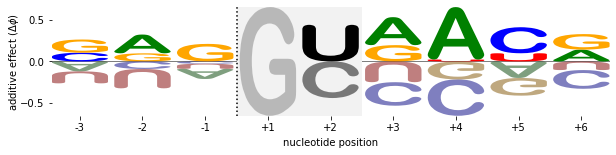

In [9]:
# Get logo dataframe
logo_df = theta_dict['logomaker_df']

# Set NaN parameters to zero
logo_df.fillna(0, inplace=True)

# Create figure
fig, ax = plt.subplots(figsize=[10,2])

# Draw logo
logo = logomaker.Logo(df=logo_df,
                      ax=ax,
                      fade_below=.5,
                      shade_below=.5,
                      width=.9,
                      font_name='Arial Rounded MT Bold')
ylim = ax.get_ylim()

# Highlight positions +1 and +2 to gray to indicate incomplete mutagenesis at these positions
logo.highlight_position_range(pmin=3, pmax=4, color='w', alpha=1, zorder=10)
logo.highlight_position_range(pmin=3, pmax=4, color='gray', alpha=.1, zorder=11)

# Create a large `G` at position +1 to indicate that only this base was present in the sequences under consideration
logo.style_single_glyph(p=3,
                        c='G',
                        flip=False,
                        floor=ylim[0],
                        ceiling=ylim[1],
                        color='gray',
                        zorder=30,
                        alpha=.5)

# Make 'C' and 'U' at position +2 black
logo.style_single_glyph(p=4, c='U', color='k', zorder=30, alpha=1)
logo.style_single_glyph(p=4, c='C', color='k', zorder=30, alpha=.5)

# Style logo
logo.style_spines(visible=False)
ax.axvline(2.5, linestyle=':', color='k', zorder=30)
ax.set_ylabel('additive effect ($\Delta \phi$)', labelpad=-1)
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels([f'{x:+d}' for x in range(-3,7) if x!=0])
ax.set_xlabel('nucleotide position', labelpad=5);

To visualize the pariwise parameters, we use the built-in function `mavenn.heatmap_pariwise()`.

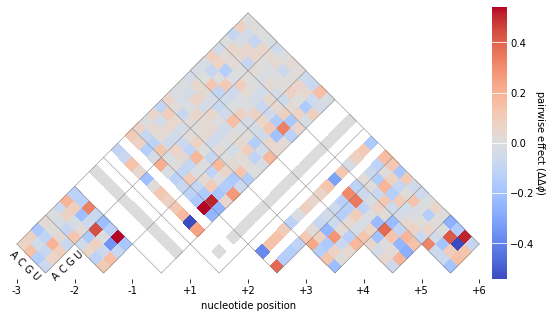

In [10]:
# Get pairwise parameters from theta_dict
theta_lclc = theta_dict['theta_lclc']

# Create fig and ax objects
fig, ax = plt.subplots(figsize=[10,5])

# Draw heatmap
ax, cb = mavenn.heatmap_pairwise(values=theta_lclc,
                                 alphabet='rna',
                                 ax=ax,
                                 gpmap_type='pairwise',
                                 cmap_size='3%')

# Style heatmap
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels([f'{x:+d}' for x in range(-3,7) if x!=0])
ax.set_xlabel('nucleotide position', labelpad=5)

# Style colorbar
cb.set_label('pairwise effect ($\Delta \Delta \phi$)',
             labelpad=5, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')

## References
1. Wong MS, Kinney JB, Krainer AR. Quantitative activity profile and context dependence of all human 5’ splice sites. Mol Cell 71:1012-1026.e3 (2018).
2. Tareen A, Kooshkbaghi M, Posfai A, Ireland WT, McCandlish DM, Kinney JB. MAVE-NN: learning genotype-phenotype maps from multiplex assays of variant effect. bioRxiv doi:10.1101/2020.07.14.201475 (2020).
3. Tareen A, Kinney JB. Logomaker: beautiful sequence logos in Python. Bioinformatics 36:2272–2274 (2019).
